In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib
import seaborn as sns

In [2]:
matplotlib.rcParams['figure.figsize'] = (10, 8) # set default figure size, 8in by 6in
%matplotlib inline

# Decision Trees

Like SVMs, *Decision Trees* are versatile machine learning algorithms that can perform both classification
and regression tasks.  They are very powreful algorithms, capable of fitting complex datasets.

Decision Trees are also the fundamental components of *Random Forests*, which are basically a collection, an
ensemble if you will, of several separately trained decision trees.

# Training and Visualizing a Decision Tree

To understand Decision Trees, let's just jump into building and training on.  The following code trains a
`DecisionTreeClassifier` from the `scikit-learn` library.  We will train the Decision Tree on the
iris dataset (see [here](https://en.wikipedia.org/wiki/Iris_flower_data_set) for more details about 
this dataset if you are not familiar with it).

In [3]:
# just fyi, get a sense of the data set
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


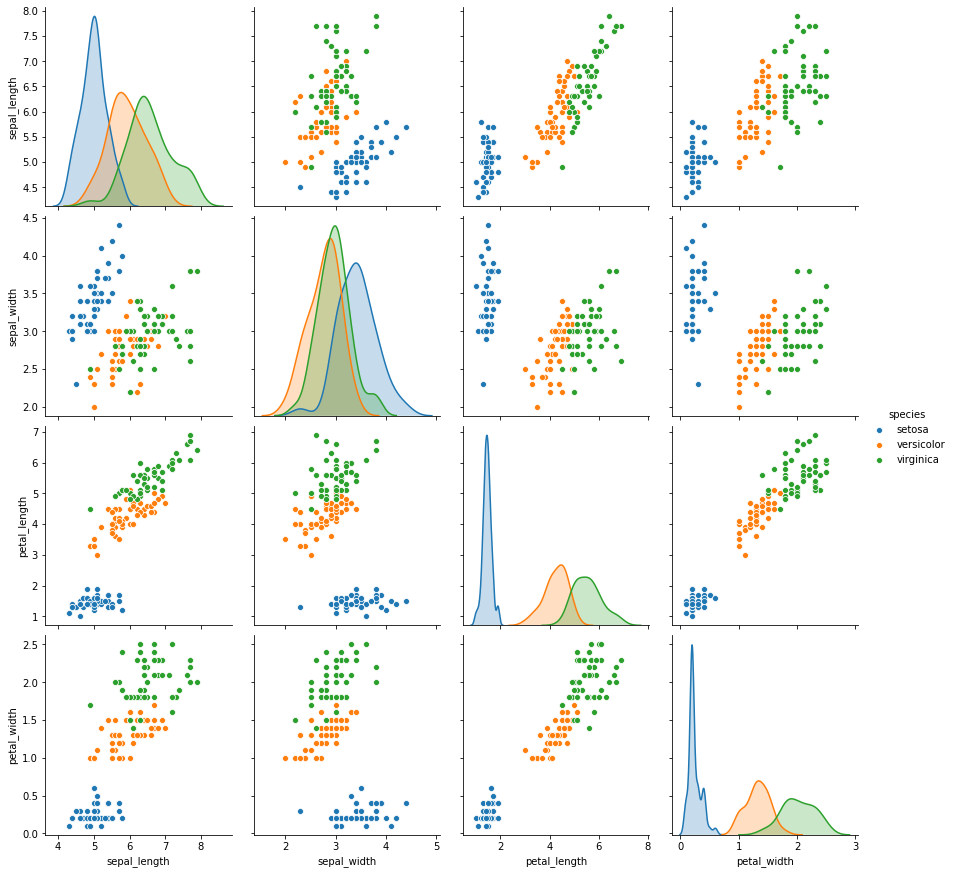

In [4]:
# also fyi, visualize the 4 parameters
sns.pairplot(iris, hue='species', height=3.0);

In [5]:
# just get the petal length and width, we reload the data from sklearn, which already has the labels
# converted to integers
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

In [6]:
# create a Decision Tree classifier and fit it to the data
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

We can visualize the trained Decision Tree by first using the export_graphviz() method to output a graph
definition file called `iris_tree.dot`

In [7]:
from sklearn.tree import export_graphviz
export_graphviz(
   tree_clf,
   out_file = '../figures/iris_tree.dot',
   feature_names = iris.feature_names[2:],
   class_names = iris.target_names,
   rounded=True,
   filled=True)

You can convert this `.dot` file to a variety of formats such as PDF or PNG using the dot command-line tool
from the `graphviz` package.  (From conda try 'conda install -c anaconda graphviz'). The following command line command converts the `.dot` file to a `.png` image file:

The following line will not work unless you have the `graphviz` package installed and the `dot` command line
tool available.  However, the image is in your repository, so you should be able to see the one generated for you
even if you can't generate it for yourself.

In [8]:
!dot -Tpng ../figures/iris_tree.dot -o ../figures/iris_tree.png

The decision tree should looks like the following 

<img src="../figures/iris_tree.png">

# Making Predictions 
The decision tree is a binary tree.  At each node a feature is tested, and based on the test you either make a decision
to proceed to the left or right in the tree.   For example, the root decision (at the top of the tree) tests if the
petal length is less than 2.45 (cm).  If this is true, we proceed to the left.  All of the colored nodes in the
figure represent leaf nodes, and when you reach a leaf node then a decision is made.  If you proceed to the left,
the decision tree will classifiy the input as being in the `setosa` class.  

If however the petal length is greater than 2.45, you would instead move to the right.  Here we have not yet reached
a leaf node, so instead a second decision is made, in this case by testing the petal width.  Based on that decision,
you would proceed either left or right to the leaf nodes representing decisions for `versicolor` and `virginica`
classes respectively.  

**Note**: One nice quality about the way a decision tree works is that they require very little data preparation.
In particular, they do not require feature scaling or centering at all.  This is because, unlike for logistic regression and SVM, we are not multiplying the features times a $\theta$ parameter.  This multiplication of feature times a weighted parameter means that feautres on a larger scale might have much larger effects on the prediction than small scaled features.  This does not happen for decision trees becase each decision is simply
a if/then split of the data.

In the figure, a nodes samples attribute counts how many training instances it applies to. For example, 50 training
samples have a petal length <= 2.45 cm, and 100 samples have a petal length > 2.45.  Also the value attribute
shown in the figure gives some valuable information.  For example, for the green `versicolor` leaf node, the 
`value = [0, 49, 5]` attribute means that this leaf node applies to 54 training samples, of which it 
classifies 49 of the training samples correctly as `versicolor` and 5 of the training samples incorrectly
as `virginica`.

Finally a nodes `gini` attribute measures the nodes *impurity*: a node is "pure" (gini = 0) if all training instances
it applies to belong to the same class.  For example, since the gold leaf node only applies to `setosa` training
instances, it is pure and its gini score is 0.

The Gini impurity equation is defined using this equaiton:

$$
G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2
$$

Where $p_{i,k}$ is the ratio of class k instances among the training instances in the $i^{th}$ node.  So for example,
the green node that categorizes as `versicolor` has a Gini coefficient of

$$
G_i = 1 - \Big( \frac{0}{54} \Big)^2 - \Big( \frac{49}{54} \Big)^2 - \Big( \frac{5}{54} \Big)^2 \approx 0.168
$$

We will later come back to the Gini impurity measure, but we present it here because it is the value that is used when
actually building/fitting the decision tree.

We had previously introduced the concept of decision boundaries for a classifier, and visualized the decision boundaries.
The decision boundaries created by our simple decision tree so far can be visualized as this:

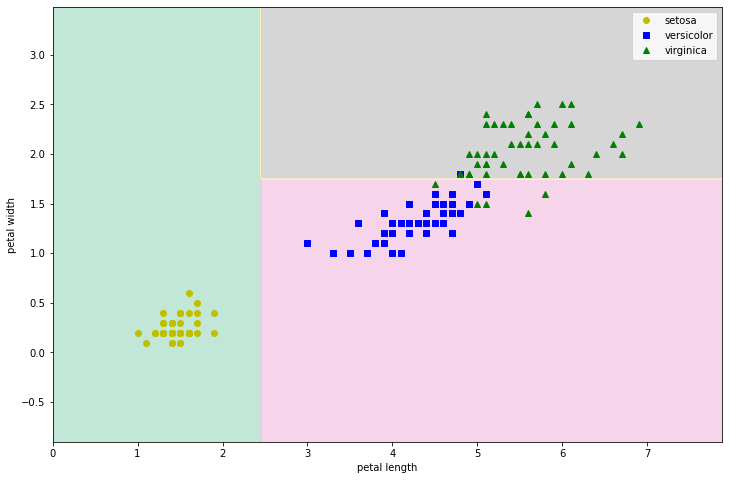

In [9]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel2, alpha=0.8);

# plot the original data
setosa_indexes = np.where(y==0)[0]
versicolor_indexes = np.where(y==1)[0]
virginica_indexes = np.where(y==2)[0]

plt.plot(X[setosa_indexes, 0], X[setosa_indexes, 1], 'yo', label='setosa')
plt.plot(X[versicolor_indexes, 0], X[versicolor_indexes, 1], 'bs', label='versicolor')
plt.plot(X[virginica_indexes, 0], X[virginica_indexes, 1], 'g^', label='virginica')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend();

When we created the decision tree classifier initialy we had specified a `max_depth` of 2, meaning that
the decision tree stops splitting/createing nodes at depth 2.  The root of the tree is considered to be at depth
0, and it makes the split based on petal length being less or greater than 2.45.  Then at dept 1 the second 
decision is made based on a petal width of 1.45.  The tree is depth 2 because all nodes are depth 2 or shallower.

However, as long as the Gini impurity score is not 0, the decision tree classifier can continue making more
finer grained decisions.  For example, if we set the `max_depth` to 3, we would get the following tree and decision
boundaries.

In [10]:
# create tree classifier with max depth of 3
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X, y)

# export tree graph of the new tree
export_graphviz(
   tree_clf,
   out_file = '../figures/iris_tree_depth3.dot',
   feature_names = iris.feature_names[2:],
   class_names = iris.target_names,
   rounded=True,
   filled=True)

# make figure from the .dot file graph
!dot -Tpng ../figures/iris_tree_depth3.dot -o ../figures/iris_tree_depth3.png

<img src="../figures/iris_tree_depth3.png">

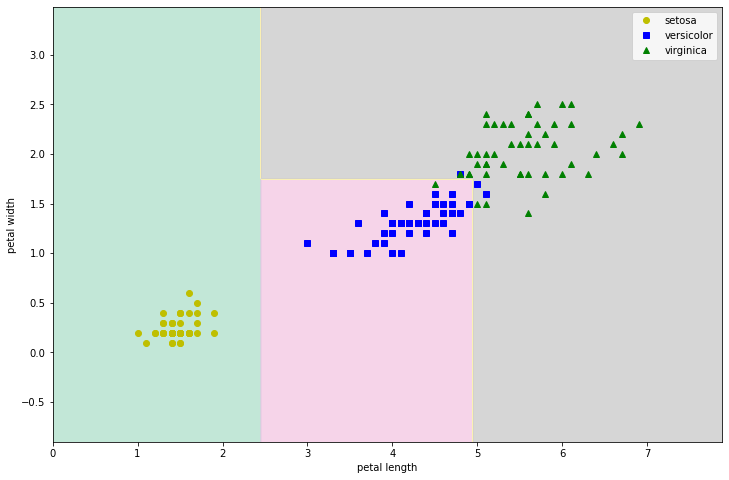

In [11]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel2, alpha=0.8);

# plot the original data
setosa_indexes = np.where(y==0)[0]
versicolor_indexes = np.where(y==1)[0]
virginica_indexes = np.where(y==2)[0]

plt.plot(X[setosa_indexes, 0], X[setosa_indexes, 1], 'yo', label='setosa')
plt.plot(X[versicolor_indexes, 0], X[versicolor_indexes, 1], 'bs', label='versicolor')
plt.plot(X[virginica_indexes, 0], X[virginica_indexes, 1], 'g^', label='virginica')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend();

Here you can see the additional decision boundary associated with the depth 2 decision.  

## Model Interpretaiton: White Box vs. Black Box

As you can see from the decision boundary and tree diagrams, a decision tree classifier is fairly intuitive and
their decisions are easy to interpret.  Such models are often called *white box models*.  In contrast, models
such as SVM, or as we will see random forests are generally considered *black box models*.  They make
good predictions, and you can easily check the calculations they perform to make these predictions.  However, unlike
for decision trees, it is much harder to give a simple explanation for why a prediection was made the way it was.
Decision trees provide nice and simple classification rules that can be applied manually if needed.

# Estimating Class Probabilities

A decision tree can also estimate the probability that an instance belongs to a particular class $k$.
Basically the ratio of the training instances (the `value` parameter in the tree diagrams) of the class $k$
is an estimate of how sure or likely we are that the current decision is correct for an unknown instance.

For example, suppose you have found a flower whose petals are 5cm long and 1.5cm wide.  If we use the
original `max_depth=2` decision tree, the corresponding leaf node is the depth-2 left node, so the decision
tree should output the following probabilities: 0% Iris-Setosa (0/54), 90.7% Iris-Versicolor (49/54) and
9.3% Iris-Virginica (5/54).  And if you ask to predict the class it should output Iris-Versicolor (class 1)
since it has the highest probability.

For example, we can use the `scikit-learn` `predict()` and `predict_proba()` functions to perform these predictions. 

In [12]:
# go back to tree classifier with max depth of 2
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

print('predicted class    : ', tree_clf.predict([[5, 1.5]]))
print('class probabilities: ', tree_clf.predict_proba([[5, 1.5]]))

predicted class    :  [1]
class probabilities:  [[0.         0.90740741 0.09259259]]


# The CART Training Algorithm

So far we have been using trained decision tree classifiers, but have not yet discused how the tree is automatically
constructed from a given set of training data.  By inspection, you can see that basically something must pick
a feature, and pick a decision boundary on that feature, to try and make "good" decision boundaries given the
data we are trying to create a decision tree classifier for.

`scikit-learn` uses the *Classification and Regression Tree* (CART) algorithm to train decision trees
(also called "growing" trees).  The idea is relatively simple: the algorithm first splits the training set into two subsets using a single feature $k$ and a threshold on that feature $t_k$ (e.g. petal length $\le$ 2.45 cm).
The big question then is "How does it choose a good feature $k$ and threshold $t_k$?"

The CART algorithms searches for pairs $(k, t_k)$ that produce the purest subsets (weighted by their size),
where "purity" is measured by the Gini impurity measure we introduced before.  So this allows us to define
a formal cost function that we can minimise.  The cost function that the algorithm tries to minimize is:

\begin{equation}
J(k, t_k) = \frac{m_\text{left}}{m} G_\text{left} + \frac{m_\text{right}}{m} G_\text{right}
\end{equation}

where

\begin{equation}
G_{\text{left} / \text{right} } \text{measures the impurity of the left/right subset,}\\
m_{\text{left} / \text{right} } \text{is the number of instances in the left/right subset.}
\end{equation}

One it has successfully split the training set in two, it splits the subsets using the same logic,
then the sub-subsets and so on recursivly.  It stops recursing once it reaches the maximum depth, or if it cannot
find a split that will reduce the $J$ cost, which is a measure of the impurity remaining.

The CART algorithm is a *greedy algorithm*.  It greedily searches for the optimum split it can
find at the top level, then repeats the process at each depth level of the tree.  It does not check
whether or not the split will lead to the lowes possible impurity over severl levels.  A greedy algorithm
often produces a reasonably good solution, but it is not guaranteed to be the optimal solution.

Unfortunately an optimal cost function over all levels is impractical for the CART algorith, as finding
the optimal tree is known to be an *NP-Complete* problem: it requires $\mathcal{O}(e^m)$ time, e.g. it is
exponential in the number of training instances $m$, making the problem intractable even for fairly small
training sets.  This is why we must instead settle for a "reasonably good" algorithm using a greedy
split at each level rather than trying to find an overall minimal cost tree.

# Computational Complexity

Making predictions requires traversing the decision tree from root to leaf.  Decision trees are generally approximately balanced, so traversing the decision tree requires going through roughly $\mathcal{O}(\log_2 m)$
nodes.  Since each node only requires checking the value of 1 feature, the overall prediction complexity
is also just $\mathcal{O}(\log_2 m))$, independent of the number of features.  So predictions are fast, even when
dealing with large training sets.

However the training algorithm compares all features on all samples at each node.  This results in a training
complexity of $\mathcal{O}(n \times m \log m)$.  Basically to determine the best split for each node, we have to
consider all $n$ features, and consider many possible splits for each feature, computing the cost function for each,
to find an optimum.

# Gini Impurity or Entropy?

By default for `scikit-learn` the Gini impurity measure is used to calculate the cost function of the decision
tree splits.  But you can select a different also commonly used measure known as the *entropy* impurity measure
instead by setting the `criterion` hyperparameter to "entropy".  

A sets entropy is zero when it contains instances of only one class, thus it is a similar concept to the Gini impurity measure.  e.g. both will be 0 when all instances in a set are of 1 class.  The entropy
of the $i^{\text{th}}$ node is given by:

\begin{equation}
H_i = -\sum_{k=1 \\ p_{i,k} \ne 0 }^n p_{i,k} \log ( p_{i,k} )
\end{equation}

Thus it is the sum of these whenever the ratio $p_{i,k}$ is not 0.  For the example depth-2 left node
we calculated before, it has an entropy impurity measure of

\begin{equation}
H_i = -\frac{49}{54} log (\frac{49}{54}) - \frac{5}{54} \log (\frac{5}{54}) \approx 0.31
\end{equation}

So which should you use regularly?  Usually it does not make a big difference, they should lead to
similar trees since the measures are similar.  Gini impurity is slightly faster to compute, so it is
a good default.  However, when they differ, the Gini impurity tends to isolate the most frequent class in
its own branch of the tree, while entropy tends to produce slightly more balanced trees (which
is a good thing).

# Regularization Hyperparameters

Decision trees make very few assumptions about the training data.  If left unconstrained, the tree structure can
adapt itself very closely to the training data, most likely badly overfitting it.  Such a model is known as
a *nonparametric model*, not because it does not have any parameters (it often has a lot), but because
the number of parameters is not determined prior to training.  This results in a training that just keeps adding
parameters (decision nodes in this case) untill the impurity is reduced to 0, meaning the classifier will perfectly
predict the training data, but is most likely badly overfit and will perform poorly on unseen data.

In contrast a *parametric model* has a predetermined number of parameters.  Linear regression, for example, is a
parametric models, the number of parameters is fixed beforehand, e.g. we assume a linear relationship, thus we
have only 2 parameters, an intercept parameter and a slope parameter to define the line we try and fit to the data.

To avoid overfitting when using decision trees, we need to restrict their freedom during training.  Decision
trees in `scikit-learn` support several regularization methods and hyperparameters to prevent this overfitting.
Limiting the maximum depth of the resulting decision tree is one example of regularizing and constraining the
model parameters.

Some other parameters you can use to regularize a decision tree in `scikit-learn` include:

- `min_samples_split` The minimum number of samples a node must have before it can be split
- `min_samples_leaf` The minum number of samples a leaf node must have
- `max_leaf_nodes` The maximum number of leaf nodes that can end up in the decision tree
- `max_features` The maximum nunber of feathres that are evaluated for splitting each node.

# Regression

Though at first glance it might not seem that decision trees can perform regression tasks, since we
are proposing discrete threshold boundaries to separate data based on features, it is actually the
case that you can also use decision trees for regression problems.  The best way to think of this is that, over
a particular range, you learn a linear approximation for a feature(s) on that range.

For example, we can train a decision tree on a noisy quadratic data set (like similar to what we used in a previous
assignment).  The `DecisionTreeRegressor` class is used for creating decision trees on regression data.

A decision tree with a `max_depth=2` looks like the following:

In [13]:
def make_quadratic_dataset(m, a=4.0, b=-4.0, c=1.2, mu=0.0, sigma=0.15):
    """Make a randomly generated artifical quadratic regression data set.  We generate and return 2 arrays,
    the x samples, and the y regression targets.  x values are sampled randomly in the interval from
    [-1.0, 1.0].  The y regression is a cubic polynomial function of the form y = ax^3 + bx^2 + cx + d
    In addition, random gaussian noise is added to each sampled point with mean of mu, and standard deviation
    of sigma
    
    Parameters
    ----------
    m - Number of random samples to artificially generate (an integer value >= 1)
    a, b, c - terms of the quadratic polynomial used to generate the random data set
    mu, sigma - terms controlling the amount of random noise added to each artifically sampled point, where
      mu is the mean of the gaussian noise to generate and sigma is the standard deviation of the noise to
      be generated and added to the samples.
    
    Returns
    -------
    x - A NumPy array of shape (m,) (a vector).  The m samples are all in the range from [0.0, 10.0]
    y - A NumPy array of shape (m,) (a vector).  The regression targets generated by the underlying cubic
        function plus some added noise
    """
    # step 1, generate m random values for the x independent feature, in the range [-1.0, 1.0]
    x = np.random.rand(m)
    
    # step 2, generate y from the described cubic function and the a,b,c,d parameters
    y = a * x**2 + b * x + c
    
    # step 3, generate m samples of gaussian noise with a mean of mu and a standard deviation of sigma
    y = y + np.random.normal(mu, sigma, size=(m,))
    
    # step 4, return the x,y (independent variable, dependent variable) random sample pairs
    return x, y

In [14]:
x,y = make_quadratic_dataset(250)
X = x.reshape((250,1))

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

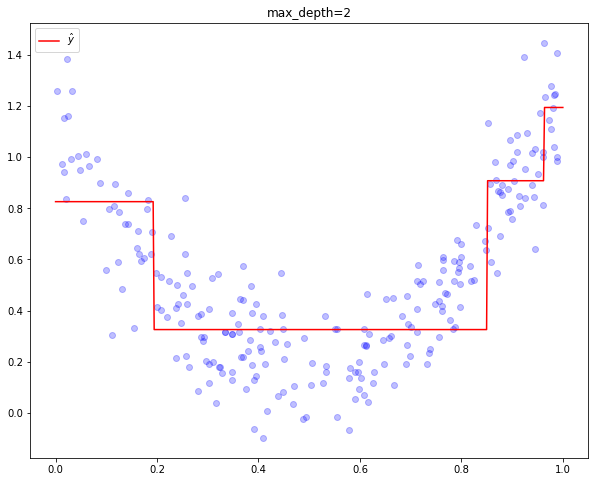

In [16]:
plt.figure(figsize=(10,8))

# plot the raw noisy data
plt.plot(x,y, 'bo', alpha=0.25);

# plot the prediciton/decisions
X_pred = np.linspace(0.0, 1.0, 500).reshape((500,1))
y_pred = tree_reg.predict(X_pred)
plt.plot(X_pred, y_pred, 'r-', label='$\hat{y}$')
plt.title('max_depth=2')
plt.legend();

The model's predictions will be linear segments with decision boundaries, in this case controlled by the
`max_depth=2` parameter.  If we increase the to `max_depth=3` we can of course improve the fit.

In [17]:
tree_reg = DecisionTreeRegressor(max_depth=3)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=3)

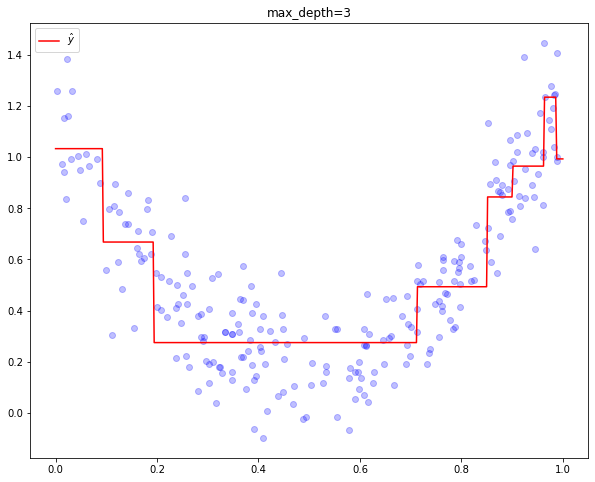

In [18]:
plt.figure(figsize=(10,8))

# plot the raw noisy data
plt.plot(x,y, 'bo', alpha=0.25);

# plot the prediciton/decisions
X_pred = np.linspace(0.0, 1.0, 500).reshape((500,1))
y_pred = tree_reg.predict(X_pred)
plt.plot(X_pred, y_pred, 'r-', label='$\hat{y}$')
plt.title('max_depth=3')
plt.legend();

The CART algorithm works mostly the same was as described earlier, except that instead of trying to
split the training set in a way that minimizes impurity, it now tries to split the training set in a way
that minimizes the MSE.  

Just like for classification tasks, decision trees are prone to overfitting when dealing with regression tasks.  Without
any regularization (using default hyperparameters), you get predictions like the following (with no restrictions
on depth).

In [19]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X, y)

DecisionTreeRegressor()

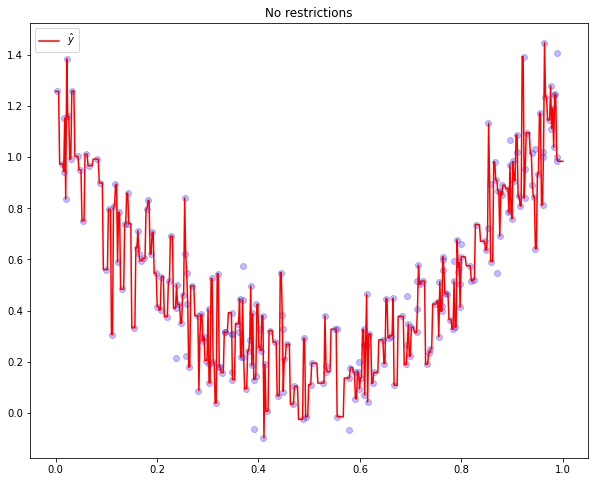

In [20]:
plt.figure(figsize=(10,8))

# plot the raw noisy data
plt.plot(x,y, 'bo', alpha=0.25);

# plot the prediciton/decisions
X_pred = np.linspace(0.0, 1.0, 500).reshape((500,1))
y_pred = tree_reg.predict(X_pred)
plt.plot(X_pred, y_pred, 'r-', label='$\hat{y}$')
plt.title('No restrictions')
plt.legend();

If it is not obvious, this is badly overfit, with one decision now for every one of the input training samples.

If we set `min_samples_leaf=10` we get a much more reasonable regression model:

In [21]:
tree_reg = DecisionTreeRegressor(min_samples_leaf=10)
tree_reg.fit(X, y)

DecisionTreeRegressor(min_samples_leaf=10)

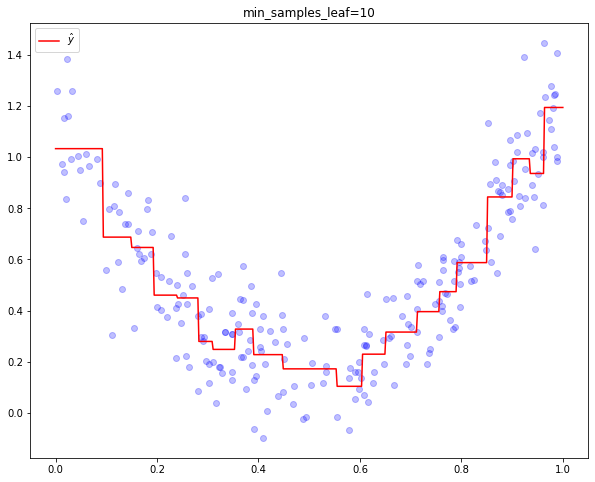

In [22]:
plt.figure(figsize=(10,8))

# plot the raw noisy data
plt.plot(x,y, 'bo', alpha=0.25);

# plot the prediciton/decisions
X_pred = np.linspace(0.0, 1.0, 500).reshape((500,1))
y_pred = tree_reg.predict(X_pred)
plt.plot(X_pred, y_pred, 'r-', label='$\hat{y}$')
plt.title('min_samples_leaf=10')
plt.legend();

In [23]:
import sys
sys.path.append("../src") # add our class modules to the system PYTHON_PATH

from ml_python_class.custom_funcs import version_information
version_information()

              Module   Versions
--------------------   ------------------------------------------------------------
         matplotlib:   ['3.2.2']
              numpy:   ['1.18.5']
             pandas:   ['1.0.5']
            seaborn:   ['0.10.1']
